In [1]:
import numpy as np
from modules import node, sensing, system
from modules import optimization as opt
from configs import config

noise_power = config.NOISE_POWER

In [2]:
tx = node.TX(x=0, y=0, z=10)
rx = node.RX(x=50, y=50, z=1.5)
ris = node.RIS(x=10, y=50, z=2, N=100)

sys = system.System(tx, ris, rx)

# generate a channel h
sys.gen_channels(is_los=False)

In [3]:
# sending samples and collect observation:
N_samples = 2000
X = np.zeros(shape=(sys.ris.N, N_samples))
y = np.zeros(shape=(N_samples, 1))

for i in range(N_samples):
    # generate a random ris setting
    sys.ris.set_random_binary_phase_shifts()
    x = sys.ris.vector_x
    X[:, i] = x.flatten()
    y[i] = sys.cal_snr() - sys.c_true

Perfect CSI

In [4]:
sys.ris.theta, sys.ris.vector_x = opt.perfect_csi(h_0=sys.h_0, h_=sys.h)
perfect_csi = 10 * np.log10(sys.cal_snr())

RMS + RFocus + CSM

In [5]:
# RMS
sys.ris.vector_x = opt.RMS(X, y)
rms = 10 * np.log10(sys.cal_snr())
# RFocus
sys.ris.vector_x = opt.RFocus(X, y)
rfocus = 10 * np.log10(sys.cal_snr())
# Conditional Sample Mean
sys.ris.vector_x = opt.CSM(X, y)
csm = 10 * np.log10(sys.cal_snr())

BORN: Sensing + Optimization

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


Variance of the last 5 estimates = 0.0012643338159027818
Consider to increase the batch size or number of samples.


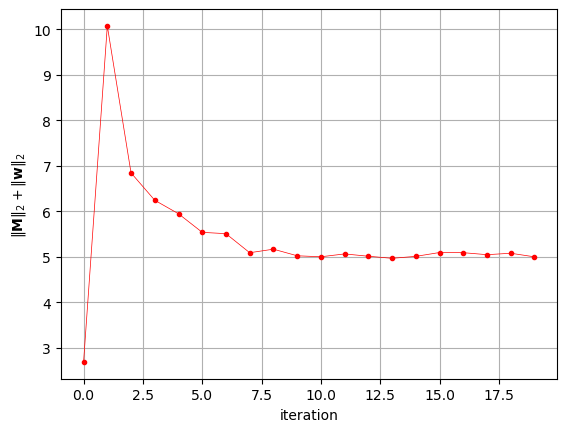

Variance of the last 5 estimates = 0.0012643338159027818


In [6]:
sens = sensing.Sensing(B=1000, N=sys.ris.N)
M_est, w_est, all_norms = sens.solve(X=X, y=y, err_var=10**-6, convergence_plot=True)
print(f"Variance of the last 5 estimates = {np.var(all_norms[-5:])}")
M_est_proj = sens.project_to_psd_lowrank(M_est, r=2)

In [7]:
sys.M_true[:2, :2], M_est[:2, :2], M_est_proj[:2, :2], w_est[:2], sys.w_true[:2]

(array([[0.06297499, 0.04244301],
        [0.04244301, 0.02868932]]),
 array([[0.05383481, 0.04123529],
        [0.04123529, 0.0317398 ]]),
 array([[0.05383816, 0.04123685],
        [0.04123685, 0.03174053]]),
 array([[-0.00420533],
        [ 0.04330953]]),
 array([[0.],
        [0.]]))

In [8]:
sys.ris.vector_x= opt.solve_our_optimization(M_est_proj, w_est)
sys.ris.theta= np.arccos(sys.ris.vector_x)
our = 10 * np.log10(sys.cal_snr())

GCSM (group the elements)

In [9]:
sys.run_GCSM(N_samples=N_samples)
gcsm = 10 * np.log10(sys.cal_snr())

In [10]:
print('Performance benchmarks')
print(f'{"RMS":<15}: {rms:.3f} dB')
print(f'{"RFocus":<15}: {rfocus:.3f} dB')
print(f'{"CSM":<15}: {csm:.3f} dB')
print(f'{"GCSM":<15}: {gcsm:.3f} dB')
print(f'{"__Proposed BORN":<15}: {our:.3f} dB')
print(f'{"__Perfect CSI__":<15}: {perfect_csi:.3f} dB')

Performance benchmarks
RMS            : 16.454 dB
RFocus         : -0.327 dB
CSM            : 7.847 dB
GCSM           : 20.882 dB
__Proposed BORN: 22.829 dB
__Perfect CSI__: 22.880 dB
